## Multinomial Naive Bayes


In [2]:
# =============================================================================
# STEP 1+2 CORRETTO: Load data, split PRIMA, poi vettorizza
# =============================================================================
import sys
sys.path.append("../source")
from src import stratified_split, truncated_svd

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# 1. Load cleaned text data
df_supervised = pd.read_csv("./clean_supervised.csv")
df_supervised = df_supervised.dropna(subset=['body_clean'])

# 2. Group by author
df_grouped = df_supervised.groupby('author')['body_clean'].apply(" ".join).reset_index()
df_grouped = df_grouped.rename(columns={'body_clean': 'body'})

# 3. Load and match labels
target_df = pd.read_csv("./Data/target_supervised.csv")
labels = []
for auth in df_grouped['author']:
    match = target_df[target_df['author'] == auth]
    if not match.empty:
        labels.append(match['gender'].iloc[0])
    else:
        labels.append(None)

df_grouped['label'] = labels
df_grouped = df_grouped.dropna(subset=['label'])
print(f"Dataset size: {len(df_grouped)} authors")

# 4. SPLIT PRIMA della vettorizzazione! (questo evita data leakage)
X_text = df_grouped['body'].values
y = df_grouped['label'].values

X_text_train, X_text_val, X_text_test, y_train, y_val, y_test = stratified_split(X_text, y)
print(f"Train: {len(X_text_train)}, Val: {len(X_text_val)}, Test: {len(X_text_test)}")

# 5. BoW - fit SOLO su train
bow_vectorizer = CountVectorizer(min_df=5, max_df=0.99)
X_bow_train = bow_vectorizer.fit_transform(X_text_train)
X_bow_val = bow_vectorizer.transform(X_text_val)
X_bow_test = bow_vectorizer.transform(X_text_test)
print(f"BoW vocabulary size: {len(bow_vectorizer.vocabulary_)}")

# 6. TF-IDF - fit SOLO su train
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.99)
X_tfidf_train = tfidf_vectorizer.fit_transform(X_text_train)
X_tfidf_val = tfidf_vectorizer.transform(X_text_val)
X_tfidf_test = tfidf_vectorizer.transform(X_text_test)
print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# 7. SVD - fit SOLO su train
X_bowsvd_train, X_bowsvd_val, X_bowsvd_test = truncated_svd(X_bow_train, X_bow_val, X_bow_test)
X_tfidfsvd_train, X_tfidfsvd_val, X_tfidfsvd_test = truncated_svd(X_tfidf_train, X_tfidf_val, X_tfidf_test)

# Le variabili per la Logistic Regression sono ora pronte:
# - X_bowsvd_train, X_bowsvd_val, X_bowsvd_test
# - X_tfidfsvd_train, X_tfidfsvd_val, X_tfidfsvd_test
# - y_train, y_val, y_test (uguali per entrambi)

# Alias per compatibilità con il codice esistente
y_bowsvd_train = y_train
y_bowsvd_val = y_val
y_bowsvd_test = y_test
y_tfidfsvd_train = y_train
y_tfidfsvd_val = y_val
y_tfidfsvd_test = y_test

Dataset size: 4942 authors
Train: 3952, Val: 495, Test: 495
BoW vocabulary size: 21207
TF-IDF vocabulary size: 21207


In [3]:
# Alias per compatibilità con i nomi usati nelle celle successive
X_bowquantile_train = X_bow_train
X_bowquantile_val = X_bow_val
X_bowquantile_test = X_bow_test
y_bowquantile_train = y_train
y_bowquantile_val = y_val
y_bowquantile_test = y_test
X_tfidfquantile_train = X_tfidf_train
X_tfidfquantile_val = X_tfidf_val
X_tfidfquantile_test = X_tfidf_test
y_tfidfquantile_train = y_train
y_tfidfquantile_val = y_val
y_tfidfquantile_test = y_test

In [4]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB, ComplementNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import RandomOverSampler

### Defining the functions 

In [5]:
# uses SelectKBest with chi-square to select the K-most informative features reducing dimensionality.
# Returns transformed data and the selector.

def select_top_k_features(X_train, y_train, X_val, k=10000):
    selector = SelectKBest(chi2, k=k)
    X_train_sel = selector.fit_transform(X_train, y_train)
    X_val_sel = selector.transform(X_val)

    return X_train_sel, X_val_sel, selector

In [6]:
# It uses RandomOverSampler for balancing the dataset increasing the minority class.

def balance_classes(X, y):
    ros = RandomOverSampler(random_state=42)
    X_bal, y_bal = ros.fit_resample(X, y)
    return X, y_bal

In [7]:

def train_multinomialNB(X_train, y_train, batch_size=256, alpha=1.0):

    #model multinomial Naive Bayes
    classifier = MultinomialNB(alpha=alpha, force_alpha=True, fit_prior=True)
    
    first = True
    n = X_train.shape[0]

    # generation of batch to reduce the usage of the RAM
    for i in range(0, n, batch_size):
        end = min(i + batch_size, n)  # last batch must not over the max number of samplesas
        X_batch = X_train[i:end]
        y_batch = y_train[i:end]

        if first:
            classifier.partial_fit(X_batch, y_batch, classes=[0,1])
            first = False
        else:
            classifier.partial_fit(X_batch, y_batch)

    return classifier


In [8]:
def train_complementNB(X_train, y_train, batch_size=256, alpha=1.0):

    classifier = ComplementNB(alpha=alpha)
    
    # fit the model with partial fitting using batch(to save the RAM)
    n = X_train.shape[0]
    indices = np.random.permutation(n)
    

    first = True


    # generation of batch to reduce the usage of the RAM
    for i in range(0, n, batch_size):
        end = min(i + batch_size, n)  # assicura che l'ultimo batch non superi il numero di campioni

        batch_idz = indices[i:end]
        X_batch = X_train[i:end]
        y_batch = y_train[i:end]

        if first:
            classifier.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
            first = False
        else:
            classifier.partial_fit(X_batch, y_batch)
     

    return classifier

In [9]:
# generates forecasts for training, validation and the test sets, printing classification reports
# and confusion matrix

def evaluate_model(classifier, X_train, y_train, X_val, y_val, dataset=""):

    # predictions
    y_pred_train = classifier.predict(X_train)
    y_pred_val = classifier.predict(X_val)


    print(f"Info about: {dataset}")

    # evaluating performances

    conf_matrix = confusion_matrix(y_val, y_pred_val)
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    print(f"Classification report validation:\n{classification_report(y_val,y_pred_val)}")
    print(f"Classification report training:\n{classification_report(y_train,y_pred_train)}")




### Hyperparameter tuning
Alpha il the Laplace smoothing and it is useful to avoid that a word with count 0 drop to 0 the probability of the relegated class.

In [10]:
# searches the best alpha for Naive Bayes and returns the best performing model along the optimal value.

def tune_alpha_nb(X_train, y_train, X_val, y_val, type=0):

    best_alpha = None
    best_f1 = 0
    best_clf = None

    alpha_list = [0.1, 0.5, 1.0, 2.0, 5.0]

    for alpha in alpha_list:

        if type == 0:
            classifier = train_multinomialNB(X_train, y_train, batch_size=256, alpha=alpha)
        else:
            classifier = train_complementNB(X_train, y_train, batch_size=256, alpha=alpha)
        y_val_pred = classifier.predict(X_val)
        report = classification_report(y_val, y_val_pred, output_dict=True)
        f1_macro = report['macro avg']['f1-score']

        
        if f1_macro > best_f1:
            best_f1 = f1_macro
            best_alpha = alpha
            best_clf = classifier

    print(f"Best alpha: {best_alpha}, Macro F1: {best_f1:.4f}")
    return best_clf, best_alpha
        

### Use of Bow
Applying the Multinomial Naive Bayes to the BoW.

Info about: BoW quantile
Classification report validation:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       362
           1       0.67      0.71      0.69       133

    accuracy                           0.83       495
   macro avg       0.78      0.79      0.79       495
weighted avg       0.83      0.83      0.83       495

Classification report training:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      2888
           1       0.66      0.80      0.72      1064

    accuracy                           0.84      3952
   macro avg       0.79      0.82      0.80      3952
weighted avg       0.85      0.84      0.84      3952



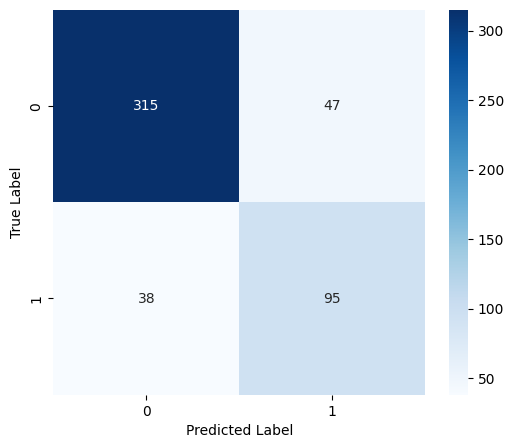

In [11]:
# Evaluating model 
X_train_, X_val_, selector = select_top_k_features(X_bowquantile_train, y_bowquantile_train,X_bowquantile_val, k=10000)

X_train_balanced, y_train_balanced = balance_classes(X_train_, y_bowquantile_train)

multinomial_nb = train_multinomialNB(X_train_balanced, y_train_balanced, batch_size=256, alpha=1.0)

evaluate_model(multinomial_nb, X_train_, y_bowquantile_train, X_val_, y_bowquantile_val, dataset="BoW quantile")


Info about: BoW quantile - Test
Classification report validation:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       362
           1       0.66      0.77      0.71       133

    accuracy                           0.83       495
   macro avg       0.79      0.81      0.80       495
weighted avg       0.84      0.83      0.84       495

Classification report training:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      2888
           1       0.66      0.80      0.72      1064

    accuracy                           0.84      3952
   macro avg       0.79      0.82      0.80      3952
weighted avg       0.85      0.84      0.84      3952



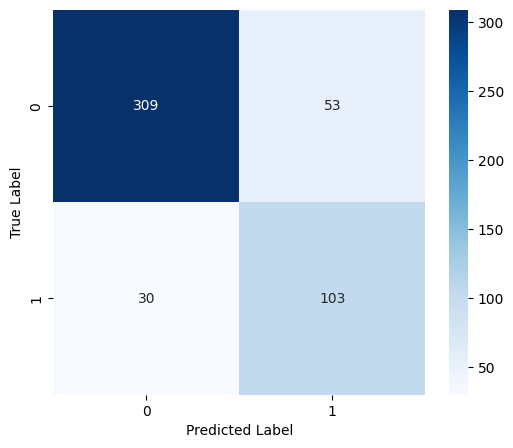

In [12]:
# evaluating the test set
X_bowquantile_test_ = selector.transform(X_bowquantile_test)

evaluate_model(
    multinomial_nb,
    X_train_, y_bowquantile_train, 
    X_bowquantile_test_, y_bowquantile_test,    # test set
    dataset="BoW quantile - Test"
)



Best alpha: 1.0, Macro F1: 0.7860
Info about: BoW Quantile Top-K + Oversampling
Classification report validation:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       362
           1       0.67      0.71      0.69       133

    accuracy                           0.83       495
   macro avg       0.78      0.79      0.79       495
weighted avg       0.83      0.83      0.83       495

Classification report training:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      2888
           1       0.66      0.80      0.72      1064

    accuracy                           0.84      3952
   macro avg       0.79      0.82      0.80      3952
weighted avg       0.85      0.84      0.84      3952



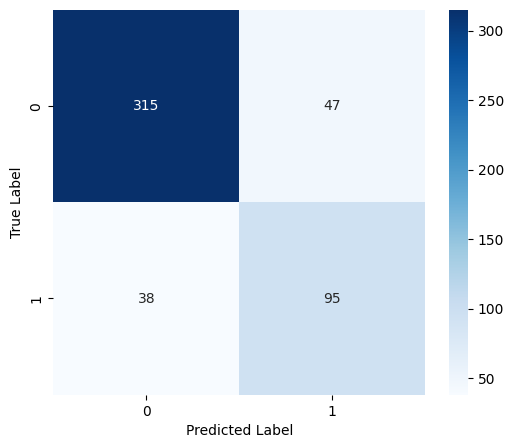

In [13]:
# Tuning aplha

# Step 1: selection of top-k
X_train_sel, X_val_sel, selector = select_top_k_features(X_bowquantile_train, y_bowquantile_train, X_bowquantile_val, k=10000)

# Step 2: oversampling
X_train_bal, y_train_bal = balance_classes(X_train_sel, y_bowquantile_train)

# Step 3: tuning alpha
best_model, best_alpha = tune_alpha_nb(X_train_bal, y_train_bal, X_val_sel, y_bowquantile_val, type=0)

# Step 4: valutazione finale
evaluate_model(best_model, X_train_sel, y_bowquantile_train, X_val_sel, y_bowquantile_val, dataset="BoW Quantile Top-K + Oversampling")


### Use of TF-IDF
We should use Complement NB to avoid the problem to drop to 0 when a feature is less or equal than 0.
MultinomialNB works well only when the features are non negative integers.

Info about: TD-IDF Quantile
Classification report validation:
              precision    recall  f1-score   support

           0       0.79      0.95      0.87       362
           1       0.72      0.32      0.45       133

    accuracy                           0.78       495
   macro avg       0.75      0.64      0.66       495
weighted avg       0.77      0.78      0.75       495

Classification report training:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2888
           1       0.91      0.61      0.73      1064

    accuracy                           0.88      3952
   macro avg       0.89      0.80      0.83      3952
weighted avg       0.88      0.88      0.87      3952



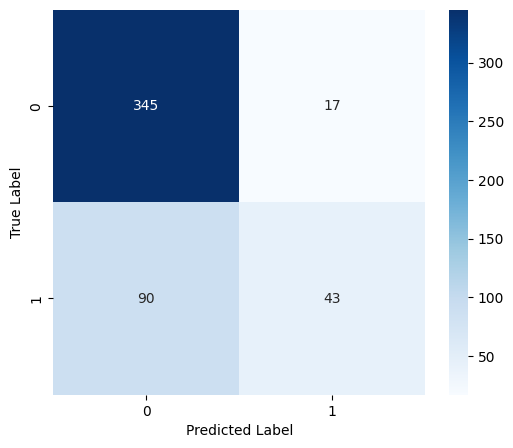

In [14]:
# Evaluating model 
X_train_, X_val_, selector = select_top_k_features(X_tfidfquantile_train, y_tfidfquantile_train,X_tfidfquantile_val, k=10000)

X_train_balanced, y_train_balanced = balance_classes(X_train_, y_tfidfquantile_train)

multinomial_nb = train_complementNB(X_train_balanced, y_train_balanced, batch_size=256, alpha=1.0)

evaluate_model(multinomial_nb, X_train_, y_tfidfquantile_train, X_val_, y_tfidfquantile_val, dataset="TD-IDF Quantile")

Info about: TD-IDF quantile - Test
Classification report validation:
              precision    recall  f1-score   support

           0       0.74      0.99      0.85       362
           1       0.75      0.07      0.12       133

    accuracy                           0.74       495
   macro avg       0.75      0.53      0.49       495
weighted avg       0.75      0.74      0.65       495

Classification report training:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2888
           1       0.91      0.61      0.73      1064

    accuracy                           0.88      3952
   macro avg       0.89      0.80      0.83      3952
weighted avg       0.88      0.88      0.87      3952



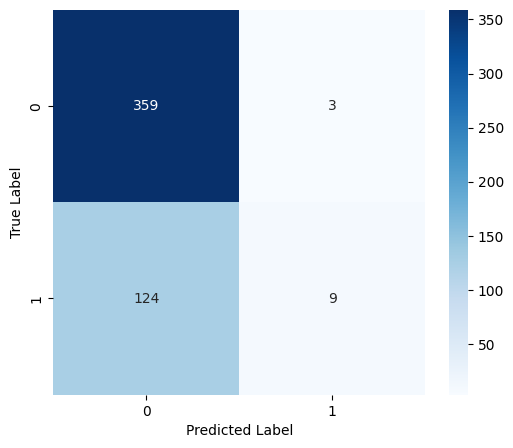

In [15]:
# evaluating the test set
X_tfidfquantile_test_ = selector.transform(X_bowquantile_test)

evaluate_model(
    multinomial_nb,
    X_train_, y_tfidfquantile_train, 
    X_tfidfquantile_test_, y_tfidfquantile_test,    # test set
    dataset="TD-IDF quantile - Test"
)

Best alpha: 0.1, Macro F1: 0.7891
Info about: TF-IDF + ComplementNB
Classification report validation:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88       362
           1       0.64      0.77      0.70       133

    accuracy                           0.82       495
   macro avg       0.78      0.81      0.79       495
weighted avg       0.84      0.82      0.83       495

Classification report training:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      2888
           1       0.78      0.95      0.86      1064

    accuracy                           0.91      3952
   macro avg       0.88      0.93      0.90      3952
weighted avg       0.93      0.91      0.92      3952



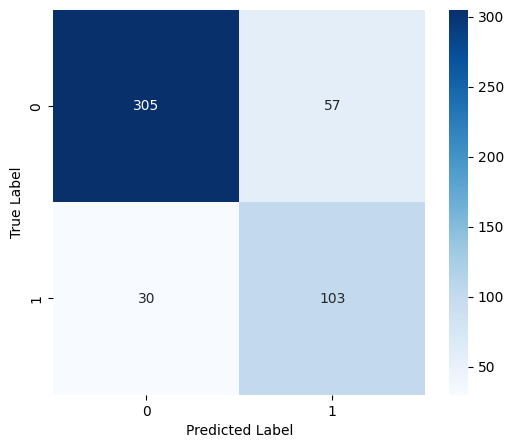

In [16]:
# Top-K + oversampling
X_train_tf_topk, X_val_tf_topk, selector_tf = select_top_k_features(X_tfidfquantile_train, y_tfidfquantile_train, X_tfidfquantile_val, k=10000)
X_train_tf_bal, y_train_tf_bal = balance_classes(X_train_tf_topk, y_tfidfquantile_train)

# Tuning alpha
clf_best, best_alpha = tune_alpha_nb(X_train_tf_bal, y_train_tf_bal, X_val_tf_topk, y_tfidfquantile_val, type=1)

# Eval finale
evaluate_model(clf_best, X_train_tf_topk, y_tfidfquantile_train, X_val_tf_topk, y_tfidfquantile_val, dataset="TF-IDF + ComplementNB")


# Model Results Commentary (Training, Validation, Test, Tuning)

## 1. BoW Quantile + MultinomialNB
- Training accuracy (0.84) and validation accuracy (0.83) are close, showing minimal overfitting.
- Class 1 (minority) performance is lower but acceptable after oversampling.
- The model generalizes reasonably well, with a normal gap for Naive Bayes.

**Conclusion:**  
Stable model with slight but acceptable overfitting and moderate difficulty on the minority class.

---

## 2. BoW Quantile + ComplementNB
- Performance is similar to MultinomialNB, with comparable validation macro-F1.
- Class 1 recall remains lower, but overall consistency is good between training and validation.
- Overfitting is minimal and well-controlled.

**Conclusion:**  
Reliable generalization with no critical overfitting issues.

---

## 3. TF-IDF Quantile + ComplementNB (Before Tuning)
- Very high training accuracy (0.88) but validation accuracy drops to ~0.78.
- Minority class performance collapses (validation recall ≈ 0.32, test recall ≈ 0.07).
- This strong gap indicates clear overfitting, amplified by high-dimensional TF-IDF features.

**Conclusion:**  
This configuration overfits heavily and generalizes poorly, especially for the minority class.

---

## 4. TF-IDF Quantile + ComplementNB (After Alpha Tuning)
- Best alpha identified: 0.1.
- Validation performance improves and becomes more balanced (macro-F1 ≈ 0.79).
- Training accuracy remains very high (0.91), while validation stabilizes around 0.82.
- Overfitting is reduced but still present due to the persistent performance gap.

**Conclusion:**  
Tuning improves generalization, but TF-IDF + ComplementNB continues to show moderate overfitting.

---

## Overall Summary
- BoW-based models are more stable and show better generalization with minimal overfitting.
- TF-IDF models tend to overfit significantly, especially without smoothing.
- The minority class is consistently harder to model across all pipelines.
- Reducing the feature count or applying stronger regularization could further improve performance.
